# 链家二手房数据爬取

In [4]:
import os
import pandas as pd
from selenium import webdriver
from pyquery import PyQuery as pq
driver = webdriver.Chrome()


'''
    步骤：
    1. 下载页面          
    2. 解析页面            
    3. 保存数据
'''


def cached_url(url):
    """
    缓存网页, 避免重复下载浪费时间
    """
    folder = 'cached'
    filename = url.split('/')[-2][2:] + '.html'   # 以页面数命名 html 页面
    path = os.path.join(folder, filename)
    if os.path.exists(path):
        with open(path, 'rb') as f:
            s = f.read()
            return s
    else:
        if not os.path.exists(folder):
            # 建立 cached 文件夹
            os.makedirs(folder)

        driver.get(url)    # 使用 Selenium 爬取页面
        with open(path, 'wb') as f:
            f.write(driver.page_source.encode())
        return driver.page_source


def house_from_div(div):
    """
    从一个 div 里面获取到一个二手房信息
    """
    e = pq(div)

    # 小作用域变量用单字符
    m = {}
    m['name'] = e('.houseInfo').text()  # 二手房名字
    m['price'] = e('.totalPrice').text()  # 二手房总价
    m['unitprice'] = e('.unitPrice').text()  # 二手房每平米单价
    m['position'] = e('.positionInfo').text()  # 二手房位置
    m['follow'] = e('.followInfo').text()  # 二手房关注信息
    m['url'] = e('a').attr('href')  # 二手房页面链接

    return m


def houses_from_url(url):
    """
    从 url 中下载网页并解析出页面内所有的房源
    """
    # 页面只需要下载一次
    page = cached_url(url)
    e = pq(page)
    items = e('.info.clear')  # 解析的class为info clear, 中间有空格, 使用“.info.clear”
    # 调用 house_from_div
    houses = [house_from_div(i) for i in items]
    return houses


def append_to_csv(data):
    '''
    保存数据
    '''
    file_name = './二手房数据.csv'
    df = pd.DataFrame(data)
    df.to_csv(file_name, mode='a', encoding='gbk', header=False, index=False)


def main():
    for i in range(1, 101):
    # 一共 100 页房源信息
        url = 'https://sh.lianjia.com/ershoufang/pg{}/'.format(i)
        houses = houses_from_url(url)
        print(houses)
        append_to_csv(houses)


if __name__ == '__main__':
    main()

[{'name': '3室1厅 | 90.51平米 | 南 | 精装 | 低楼层(共19层) | 2010年建 | 板楼', 'price': '546万', 'unitprice': '单价60325元/平米', 'position': '锦梅馨苑 - 春申', 'follow': '90人关注 / 7天以前发布', 'url': 'https://sh.lianjia.com/ershoufang/107101877790.html'}, {'name': '2室1厅 | 60.31平米 | 南 | 精装 | 中楼层(共6层) | 1996年建 | 板楼', 'price': '274.3万', 'unitprice': '单价45482元/平米', 'position': '航华一村 - 航华', 'follow': '270人关注 / 23天以前发布', 'url': 'https://sh.lianjia.com/ershoufang/107101808351.html'}, {'name': '3室2厅 | 84.49平米 | 南 | 精装 | 低楼层(共7层) | 1994年建 | 板楼', 'price': '490万', 'unitprice': '单价57996元/平米', 'position': '大上海国际花园六区 - 静安新城', 'follow': '186人关注 / 18天以前发布', 'url': 'https://sh.lianjia.com/ershoufang/107101821207.html'}, {'name': '2室2厅 | 93.35平米 | 南 | 精装 | 高楼层(共6层) | 1998年建 | 板楼', 'price': '615万', 'unitprice': '单价65882元/平米', 'position': '锦杨苑 - 东外滩', 'follow': '95人关注 / 1个月以前发布', 'url': 'https://sh.lianjia.com/ershoufang/107101688099.html'}, {'name': '3室1厅 | 81.14平米 | 南 北 | 精装 | 中楼层(共6层) | 1993年建 | 板楼', 'price': '276万', 'unitprice': '单价

# 链家二手房数据清洗

In [7]:
import numpy as np
import pandas as pd


def follow_split(df):
    # 从“发布信息”列拆分出“关注数”, “带看数”和“发布时间”
    df['关注数'] = df['发布信息'].str.split('/').str[0]
    df['关注数'] = df['关注数'].replace('[^0-9]', '', regex=True)  # 去除非数字字符
    df['关注数'] = df['关注数'].astype(int)  # 转换为数字

#     df['带看数'] = df['发布信息'].str.split('/').str[1]
#     df['带看数'] = df['带看数'].replace('[^0-9]', '', regex=True)  # 去除非数字字符
#     df['带看数'] = df['带看数'].astype(int)  # 转换为数字

    df['发布时间'] = df['发布信息'].str.split('/').str[1]
    df['发布时间'] = df['发布时间'].str.replace('以前发布', '')  # 去除字符串

    # 删除“发布信息”列
    df.drop(columns='发布信息', inplace=True)


def name_split(df):
    # 从“房源信息”列拆分出“小区名”, “房型”, “房间面积”, “房间朝向”和“房间装修类别”
#     df['小区名'] = df['房源信息'].str.split('|').str[0]

    df['房型'] = df['房源信息'].str.split('|').str[0]

    df['房间面积'] = df['房源信息'].str.split('|').str[1]
    df['房间面积'] = df['房间面积'].replace('[^0-9.]', '', regex=True)  # 去除非数字字符
    df['房间面积'] = df['房间面积'].astype(float)  # 转换为数字

    df['房间朝向'] = df['房源信息'].str.split('|').str[2]

    df['房间装修类别'] = df['房源信息'].str.split('|').str[3]

    # 删除“房源信息”列
    df.drop(columns='房源信息', inplace=True)


def position_split(df):
    # 从“房源位置”列拆分出 “层数”和“位置”
    df['小区位置'] = df['房源位置'].str.split('-').str[0]
#     df['房源总层数'] = df['房源总层数'].replace('[^0-9]', '', regex=True)  # 去除非数字字符
#     df['房源总层数'] = df['房源总层数'].astype(int)  # 转换为数字

    df['区名'] = df['房源位置'].str.split('-').str[1]
    df['区名'] = df['区名'].map(str.strip)

    # 删除“房源位置”列
    df.drop(columns='房源位置', inplace=True)


def str_2_int(df):
    df['总价'] = df['总价'].replace('[^0-9.]', '', regex=True)  # 去除非数字字符
    df['总价'] = df['总价'].astype(float)  # 转换为数字

    df['单价'] = df['单价'].replace('[^0-9.]', '', regex=True)  # 去除非数字字符
    df['单价'] = df['单价'].astype(int)  # 转换为数字


def main():
    df = pd.read_csv('二手房数据.csv', encoding='gbk', engine='python', header=None)
    df.index = np.arange(1, len(df) + 1)
    df.columns = ['发布信息', '房源信息', '房源位置', '总价', '单价', '房源链接']

    follow_split(df)  # 拆分“发布信息”列
    name_split(df)   # 拆分“房源信息”列
    position_split(df)  # 拆分“房源位置”列
    str_2_int(df)  # 将“总价”和“单价”列转换为数字

    # print(df)
    df.to_csv('./二手房数据整理.csv', encoding='gbk')  # 保存整理后的数据


if __name__ == '__main__':
    main()

# 数据可视化

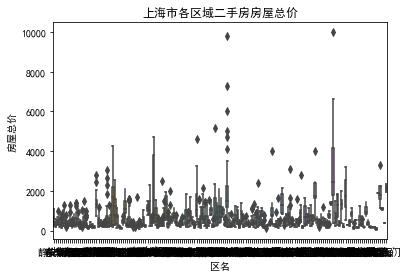

       区名             单价
0     新天地  132219.631579
1    淮海中路  116142.857143
2     衡山路  112797.625000
3    黄浦滨江  107716.571429
4    徐汇滨江  106460.555556
5    南京西路  105259.440000
6    建国西路  104448.875000
7      源深   98913.451613
8     陆家嘴   96962.984615
9    世博滨江   96719.666667
10    江宁路   96355.588235
11     豫园   95016.250000
12     联洋   94625.086957
13    静安寺   91561.500000
14     潍坊   88421.812500
15    董家渡   87225.666667
16    五里桥   86525.851852
17    徐家汇   85691.739130
18   蓬莱公园   85500.000000
19     天山   84458.000000
20    不夜城   83976.285714
21    镇宁路   83838.857143
22    曹家渡   83366.785714
23     碧云   82651.382353
24    老西门   82175.500000
25    临平路   82166.500000
26   人民广场   81648.500000
27     花木   81228.076923
28     古北   80490.777778
29    打浦桥   80346.100000
..    ...            ...
134  松江新城   35914.200000
135   老闵行   35820.804348
136    赵巷   34963.200000
137    马桥   34228.000000
138    新场   33654.333333
139    祝桥   33464.000000
140  菊园新区   32570.400000
141  松江老城   31880.250000


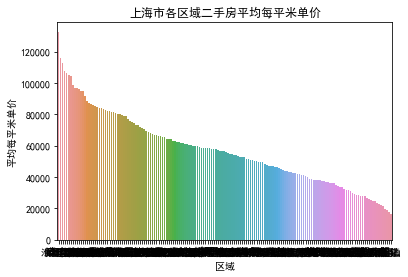

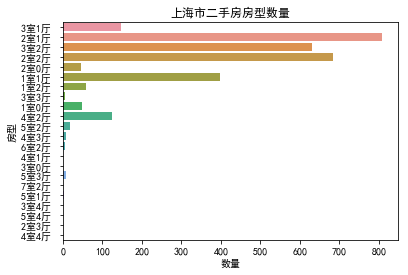

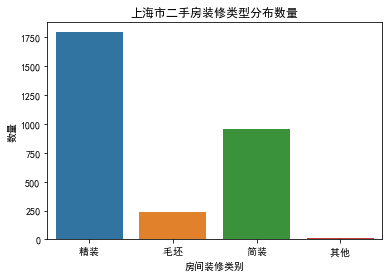

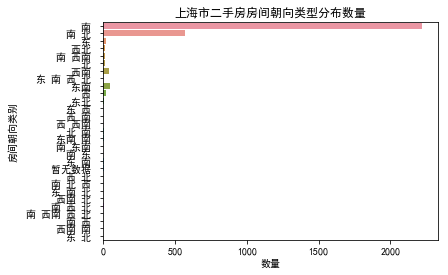

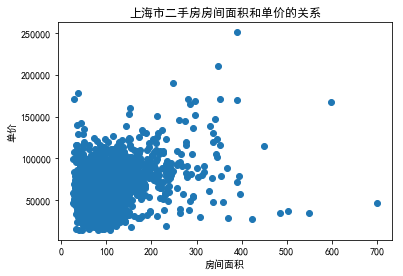

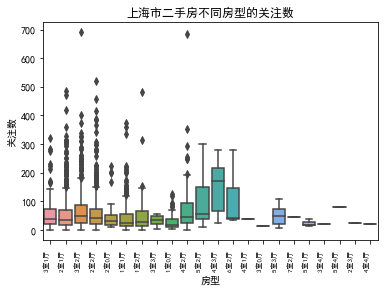

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
import seaborn as sns
%matplotlib inline

# (2):查看各区域的二手房房屋总价
def house_total_price():
    sns.boxplot(x='区名', y='总价', data=df)
    plt.xlabel('区名')
    plt.ylabel('房屋总价')
    plt.title('上海市各区域二手房房屋总价')
    plt.savefig('上海市各区域二手房房屋总价.jpg')
    plt.show()


# (3):查看各区域的二手房平均每平米单价
def house_average_unitprice():
    df_house_unitprice = df.groupby('区名')['单价'].mean().sort_values(ascending=False).to_frame().reset_index()
    print(df_house_unitprice)
    sns.barplot(x='区名', y='单价', data=df_house_unitprice)
    plt.xlabel('区域')
    plt.ylabel('平均每平米单价')
    plt.title('上海市各区域二手房平均每平米单价')
    plt.savefig('上海市各区域二手房平均每平米单价.jpg')
    plt.show()


# (4):查看上海市的二手房房型数量分布
def house_style():
    sns.countplot(y='房型', data=df)
    plt.xlabel('数量')
    plt.ylabel('房型')
    plt.title('上海市二手房房型数量')
    plt.savefig('上海市二手房房型数量.jpg')
    plt.show()


# (5):查看上海市的二手房装修类型分布
def house_decoration():
    sns.countplot(x='房间装修类别', data=df)
    plt.xlabel('房间装修类别')
    plt.ylabel('数量')
    plt.title('上海市二手房装修类型分布数量')
    plt.savefig('上海市二手房装修类型分布数量.jpg')
    plt.show()


# (6):查看上海市的二手房房间朝向分布
def house_direction():
    sns.countplot(y='房间朝向', data=df)
    plt.xlabel('数量')
    plt.ylabel('房间朝向类别')
    plt.title('上海市二手房房间朝向类型分布数量')
    plt.savefig('上海市二手房房间朝向类型分布数量.jpg')
    plt.show()


# (7):查看上海市的房间面积和单价的关系
def house_area_price_relation():
    df[['房间面积']].astype(int)  # 将房间面积转换为整数
    plt.scatter(x='房间面积', y='单价', data=df, marker='o')
    plt.xlabel('房间面积')
    plt.ylabel('单价')
    plt.title('上海市二手房房间面积和单价的关系')
    plt.savefig('上海市二手房房间面积和单价的关系.jpg')
    plt.show()


# (8):查看上海市的不同房型的关注数和带看数
def house_style_attention():
    ax = sns.boxplot(x='房型', y='关注数', data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7)
    plt.xlabel('房型')
    plt.ylabel('关注数')
    plt.title('上海市二手房不同房型的关注数')
    plt.savefig('上海市二手房不同房型的关注数.jpg')
    plt.show()

def main():
    df = pd.read_csv('二手房数据分析.csv', encoding='gbk', engine='python')
    house_total_price()
    house_average_unitprice()
    house_style()
    house_decoration()
    house_direction()
    house_area_price_relation()
    house_style_attention()
if __name__ == '__main__':
    main()